In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

# Text Preprocess
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Embedding

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Import Dataset
!kaggle datasets download tanishqdublish/text-classification-documentation

# Unzip Dataset
from zipfile import ZipFile
zip = ZipFile('/content/text-classification-documentation.zip')
zip.extractall('/content')
zip.close()

Dataset URL: https://www.kaggle.com/datasets/tanishqdublish/text-classification-documentation
License(s): apache-2.0
100% 1.85M/1.85M [00:00<00:00, 2.68MB/s]
100% 1.85M/1.85M [00:00<00:00, 2.37MB/s]


In [ ]:
dataset = pd.read_csv('/content/df_file.csv')

In [ ]:
dataset.head()

,Text,Label
0,Budget to set scene for election\n \n Gordon B...,0
1,Army chiefs in regiments decision\n \n Militar...,0
2,Howard denies split over ID cards\n \n Michael...,0
3,Observers to monitor UK election\n \n Minister...,0
4,Kilroy names election seat target\n \n Ex-chat...,0


In [ ]:
row, col = dataset.shape
label = len(dataset['Label'].unique())
print(f'Dataset contains {row} Texts which Divided into {label} Labels.')
print("""Where, \n 0 = Politics \n 1 = Sports \n 2 = Technology
 3 = Entertainment \n 4 = Business""")

Dataset contains 2225 Texts which Divided into 5 Labels.
Where, 
 0 = Politics 
 1 = Sports 
 2 = Technology
 3 = Entertainment 
 4 = Business


In [ ]:
# Checking Missing Values
dataset.isnull().sum()

,0
Text,0
Label,0


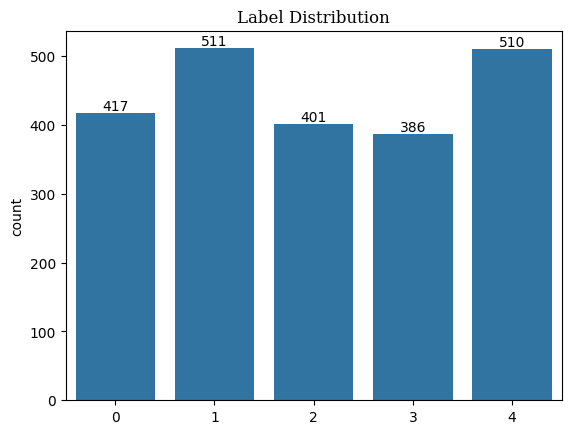

In [ ]:
ax = sns.countplot(data=dataset, x='Label')
ax.bar_label(ax.containers[0])
plt.title('Label Distribution', family='serif')
plt.xlabel('')
plt.xlabel('')
plt.show()

Text Preprocessing

In [ ]:
def text_preprocess(text):
  # Remove Special Characters
  clean_text = re.sub('[^A-Za-z]',' ',text)

  # Convert to Lowercase
  text_lower = clean_text.lower()

  # Tokens
  token = text_lower.split()

  # Removing Stopwords
  filtered = [word for word in token if word not in stopwords.words('english')]

  # Lemmatize
  word_lemma = [lemma.lemmatize(word) for word in filtered]

  return ' '.join(word_lemma)

In [ ]:
dataset['clean_text'] = dataset['Text'].apply(lambda doc:text_preprocess(doc))

In [ ]:
dataset.head()

,Text,Label,clean_text
0,Budget to set scene for election\n \n Gordon B...,0,budget set scene election gordon brown seek pu...
1,Army chiefs in regiments decision\n \n Militar...,0,army chief regiment decision military chief ex...
2,Howard denies split over ID cards\n \n Michael...,0,howard denies split id card michael howard den...
3,Observers to monitor UK election\n \n Minister...,0,observer monitor uk election minister invite i...
4,Kilroy names election seat target\n \n Ex-chat...,0,kilroy name election seat target ex chat show ...


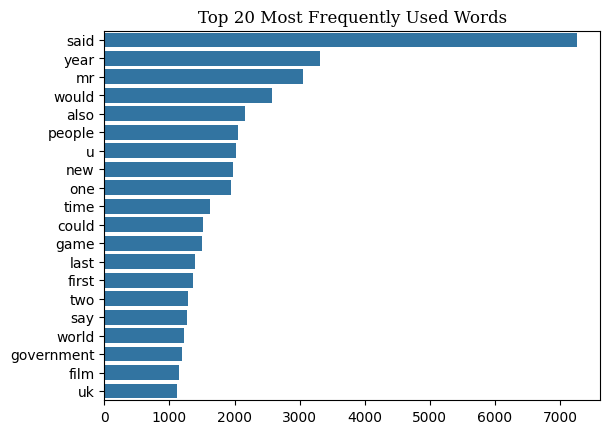

In [ ]:
# Most Frequently Used Words

all_words = ' '.join(dataset['clean_text'].values).split()
word_count = Counter(all_words)
common_words_df = pd.DataFrame(word_count.most_common(20),
                               columns=['word','count'])
sns.barplot(data=common_words_df, x='count', y='word')
plt.title('Top 20 Most Frequently Used Words', family='serif')
plt.xlabel('')
plt.ylabel('')
plt.show()

Split the Data into Train & Test

In [ ]:
x = dataset['clean_text']
y = dataset['Label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    stratify=y, random_state=42)

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Tokenize & Padding

In [ ]:
x_tokenizer = Tokenizer(oov_token='unknown')
x_tokenizer.fit_on_texts(x_train)

In [ ]:
vocab = len(x_tokenizer.word_index)
print(f'{vocab} - Unique Vocabulary')

22768 - Unique Vocabulary


In [ ]:
# Converting to Sequences
x_train_seq = x_tokenizer.texts_to_sequences(x_train)
x_test_seq = x_tokenizer.texts_to_sequences(x_test)

In [ ]:
# Padding - to make them equal length
max_len = 100
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len, padding='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len, padding='post')

In [ ]:
x_train_pad[0]

array([  697,    16,   114,   207,    59,   891,  1767,  7363,   523,
           5,   639,    13,  3001,   574,  1228,     5,    53,    74,
          33,    27,    13,    11,  7363,    29,    54,   154,   430,
           5,     6,  6675,  9617,   843,  1883,  1095,    53,    80,
         135,    40, 11471,  1228,  2431,  1708,  1883,   530,   905,
        1129,    40,   319,  9618,   556,   520,    40,    13,  5262,
         182,   156,   193,  4613,    80,   482,  1648,  1958,    40,
        1061,   780,  3001,   400,    82,   941,   245,   599,   348,
        3618,   183,  1677,   184,   441,  1008,   160,  5619,   144,
          40,   442,   171,  1343,   575,  3002,   997,  7364,  1734,
          68,   599,   820,   245,   387,    40,     6,   397,  9619,
        1009], dtype=int32)

Model Building - Simple RNN

In [ ]:
model = Sequential()

# Embedding Layer
model.add(Embedding(input_dim=22770, output_dim=50, input_length=max_len))

# SimpleRNN
model.add(SimpleRNN(64))

# Dense Layer
model.add(Dense(5, activation='softmax'))

# Model Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Fit
history = model.fit(x_train_pad, y_train, validation_data=(x_test_pad, y_test), epochs=5)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.2393 - loss: 1.6057 - val_accuracy: 0.3326 - val_loss: 1.5589
Epoch 2/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7276 - loss: 1.2114 - val_accuracy: 0.5034 - val_loss: 1.1581
Epoch 3/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9712 - loss: 0.4629 - val_accuracy: 0.4539 - val_loss: 1.1860
Epoch 4/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 1.0000 - loss: 0.0916 - val_accuracy: 0.4764 - val_loss: 1.2275
Epoch 5/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 1.0000 - loss: 0.0285 - val_accuracy: 0.4652 - val_loss: 1.3170


LSTM

In [ ]:
model = Sequential()

# Embedding Layer
model.add(Embedding(input_dim=22770, output_dim=50, input_length=max_len))

# SimpleRNN
model.add(LSTM(64))

# Dense Layer
model.add(Dense(5, activation='softmax'))

# Model Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Fit
history = model.fit(x_train_pad, y_train, validation_data=(x_test_pad, y_test), epochs=5)

Epoch 1/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.2612 - loss: 1.5526 - val_accuracy: 0.4539 - val_loss: 1.2299
Epoch 2/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.5776 - loss: 1.0999 - val_accuracy: 0.7978 - val_loss: 0.6149
Epoch 3/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.7437 - loss: 0.6967 - val_accuracy: 0.7079 - val_loss: 0.6374
Epoch 4/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.8445 - loss: 0.4464 - val_accuracy: 0.7888 - val_loss: 0.5673
Epoch 5/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.9089 - loss: 0.3672 - val_accuracy: 0.8449 - val_loss: 0.4725


In [ ]:
def prediction(text):
  # Text Preprocess
  clean_text = text_preprocess(text)

  # Tokenize
  tokens = x_tokenizer.texts_to_sequences([clean_text])

  # Padding
  pad_seq = pad_sequences(tokens, maxlen=100, padding='post')

  # Predict Probabilties
  pred = model.predict(pad_seq)
  labels = ['Politics','Sports','Technology','Entertainment','Business']

  return labels[np.argmax(pred)]

In [ ]:
prediction(dataset['Text'][416])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


'Politics'

In [ ]:
from keras.models import load_model
model.save('text_classification.h5')

In [ ]:
import joblib
joblib.dump(text_preprocess, 'preprocess.pkl')
joblib.dump(x_tokenizer, 'tokenizer.pkl')
joblib.dump(prediction, 'prediction.pkl')

['prediction.pkl']